# Stock prediction tool

**Available currencies:**

> **Bitcoin** - BTC-USD<br>
> **Ethereum** - ETH-USD<br>
> **BNB** - BNB-USD<br>
> **Dogecoin** - DOGE-USD<br>

In [71]:
import yfinance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, roc_auc_score, RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [61]:
bitcoin = yfinance.Ticker("BTC-USD")
ethereum = yfinance.Ticker("ETH-USD")
bincoin = yfinance.Ticker("BNB-USD")
dogecoin = yfinance.Ticker("DOGE-USD")

currency_names = ["Bitcoin", "Ethereum",
                  "Binance Coin", "Dogecoin"]

currencies_data = [bitcoin.history(period="max"), ethereum.history(period="max"),
                   bincoin.history(period="max"), dogecoin.history(period="max")]

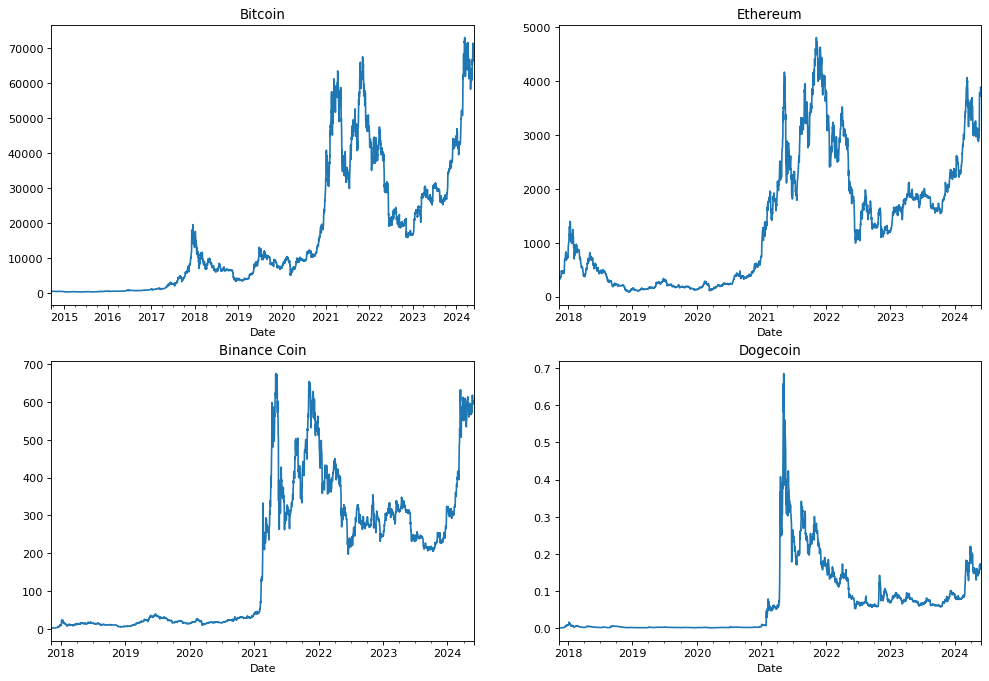

In [62]:
fig, axes = plt.subplots(figsize=(15,10), dpi=80, nrows=2, ncols=2)

for ax, name, data in zip(axes.flatten(), currency_names, currencies_data):
    data["Close"].plot(ax=ax)
    ax.set_title(name)

In [63]:
bitcoin_data = currencies_data[0]
bitcoin_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-27 00:00:00+00:00,68512.179688,70597.882812,68232.500000,69394.554688,25870990717,0.0,0.0
2024-05-28 00:00:00+00:00,69392.195312,69514.640625,67227.156250,68296.218750,32722265965,0.0,0.0
2024-05-29 00:00:00+00:00,68296.351562,68852.460938,67101.492188,67578.093750,26707072906,0.0,0.0


In [64]:
def RSI(data: pd.Series, window: int = 14) -> pd.Series:
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [67]:
bitcoin_data["1D"] = bitcoin_data["Close"].shift(1)
bitcoin_data["3D"] = bitcoin_data["Close"].shift(3)
bitcoin_data["7D"] = bitcoin_data["Close"].shift(7)
bitcoin_data["14D"] = bitcoin_data["Close"].shift(14)
bitcoin_data["31D"] = bitcoin_data["Close"].shift(31)

bitcoin_data["3DA"] = bitcoin_data["Close"].rolling(window=3).mean()
bitcoin_data["7DA"] = bitcoin_data["Close"].rolling(window=7).mean()
bitcoin_data["14DA"] = bitcoin_data["Close"].rolling(window=14).mean()
bitcoin_data["31DA"] = bitcoin_data["Close"].rolling(window=31).mean()

bitcoin_data["3DEA"] = bitcoin_data["Close"].ewm(span=3, adjust=False).mean()
bitcoin_data["7DEA"] = bitcoin_data["Close"].ewm(span=7, adjust=False).mean()
bitcoin_data["14DEA"] = bitcoin_data["Close"].ewm(span=14, adjust=False).mean()
bitcoin_data["31DEA"] = bitcoin_data["Close"].ewm(span=31, adjust=False).mean()

bitcoin_data["RSI14"] = RSI(bitcoin_data["Close"].copy(), window=14)

bitcoin_data["Growth"] = (bitcoin_data["Close"] > bitcoin_data["1D"]).astype(int)

bitcoin_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,1D,3D,7D,...,3DA,7DA,14DA,31DA,3DEA,7DEA,14DEA,31DEA,RSI14,Growth
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,457.334015,457.334015,457.334015,457.334015,NaN,0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0,457.334015,NaN,NaN,...,NaN,NaN,NaN,NaN,440.887009,449.110512,452.948147,455.278139,NaN,0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0,424.440002,NaN,NaN,...,425.523336,NaN,NaN,NaN,417.841499,435.531881,445.194526,451.498005,NaN,0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0,394.795990,457.334015,NaN,...,409.379995,NaN,NaN,NaN,413.372746,428.874909,440.355788,448.835879,NaN,1
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0,408.903992,424.440002,NaN,...,400.840332,NaN,NaN,NaN,406.096880,421.361435,434.817818,445.709950,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27 00:00:00+00:00,68512.179688,70597.882812,68232.500000,69394.554688,25870990717,0.0,0.0,68518.093750,68526.101562,71448.195312,...,69059.531250,68984.732143,67690.302176,64597.918221,69056.922070,68685.607975,67608.208012,66121.962079,65.211872,1
2024-05-28 00:00:00+00:00,69392.195312,69514.640625,67227.156250,68296.218750,32722265965,0.0,0.0,69394.554688,69265.945312,70136.531250,...,68736.289062,68721.830357,68171.975725,64755.243322,68676.570410,68588.260669,67699.942777,66257.853121,65.985823,0
2024-05-29 00:00:00+00:00,68296.351562,68852.460938,67101.492188,67578.093750,26707072906,0.0,0.0,68296.218750,68518.093750,69122.335938,...,68422.955729,68501.224330,68265.590123,64899.271169,68127.332080,68335.718939,67683.696240,66340.368160,53.833216,0


In [68]:
bitcoin_data = bitcoin_data.dropna()
bitcoin_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,1D,3D,7D,...,3DA,7DA,14DA,31DA,3DEA,7DEA,14DEA,31DEA,RSI14,Growth
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-18 00:00:00+00:00,383.976013,395.157990,378.971008,391.441986,11416800,0.0,0.0,383.757996,394.773010,362.299011,...,385.918660,388.908857,367.926076,381.975806,388.551584,384.537290,379.749475,388.411056,75.469711,1
2014-10-19 00:00:00+00:00,391.253998,393.938995,386.457001,389.545990,5914570,0.0,0.0,391.441986,382.556000,378.549011,...,388.248657,390.479854,372.857217,380.850193,389.048787,385.789465,381.055677,388.481989,79.658722,0
2014-10-20 00:00:00+00:00,389.230988,390.084015,378.252014,382.845001,16419000,0.0,0.0,389.545990,383.757996,390.414001,...,387.944326,389.398568,376.626216,380.464677,385.946894,385.053349,381.294253,388.129678,73.241668,0
2014-10-21 00:00:00+00:00,382.420990,392.645996,380.834015,386.475006,14188900,0.0,0.0,382.845001,391.441986,400.869995,...,386.288666,387.342141,380.218216,379.741162,386.210950,385.408763,381.985020,388.026261,72.644511,1
2014-10-22 00:00:00+00:00,386.118011,388.575989,382.248993,383.157990,11641300,0.0,0.0,386.475006,389.545990,394.773010,...,384.159332,385.682853,382.376644,379.235903,384.684470,384.846070,382.141416,387.721994,65.480215,0


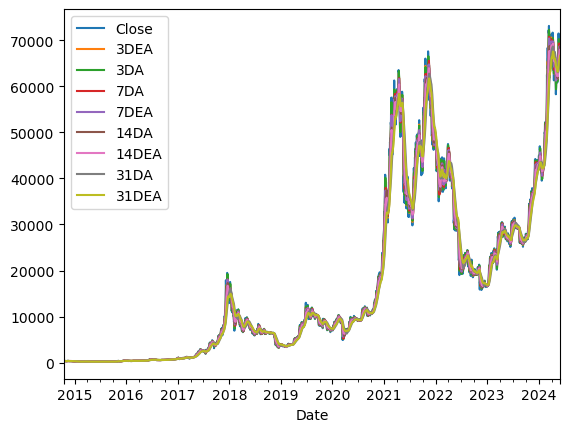

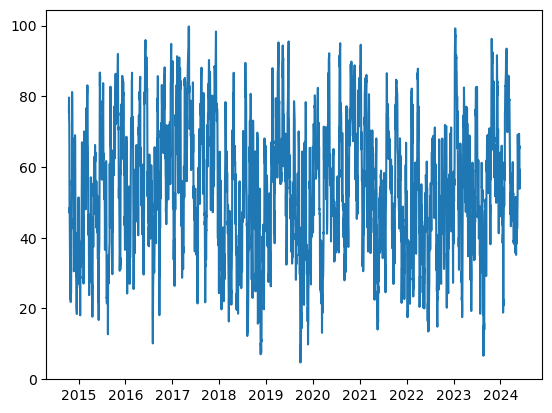

In [70]:
bitcoin_data[["Close", "3DEA", "3DA", "7DA", "7DEA", "14DA", "14DEA", "31DA", "31DEA"]].plot()
plt.show()

plt.plot(bitcoin_data["RSI14"])

In [74]:
features = ["Open", "High", "Low", "Close", "Volume",
            "1D", "3D", "7D", "14D", "31D",
            "3DA", "7DA", "14DA", "31DA",
            "3DEA", "7DEA", "14DEA", "31DEA",
            "RSI14"]

X = bitcoin_data[features]
y = bitcoin_data["Growth"]

X_train = X[X.index <= "2023-06-01"].values
X_test = X[X.index > "2023-06-01"].values

y_train = y[y.index <= "2023-06-01"].values
y_test = y[y.index > "2023-06-01"].values

In [76]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

RandomForestClassifier()

In [109]:
y_pred = rf.predict_proba(X_test)[:,1]
y_pred[y_pred > 0.65] = 1
y_pred[y_pred <= 0.65] = 0

In [110]:
y_pred

array([0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0.

In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.85      0.66       176
           1       0.69      0.32      0.43       189

    accuracy                           0.57       365
   macro avg       0.61      0.58      0.55       365
weighted avg       0.62      0.57      0.54       365



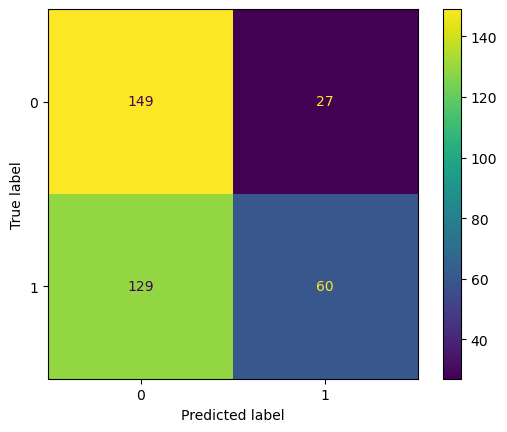

In [112]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

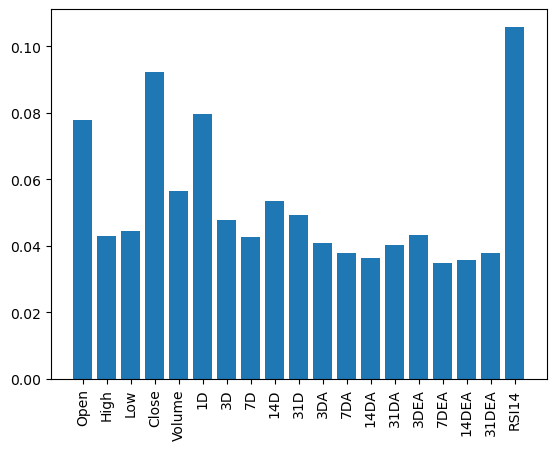

In [114]:
plt.bar(range(1, len(features)+1), rf.feature_importances_)
plt.xticks(range(1, len(features)+1), features)
plt.xticks(rotation=90)
plt.show()